### CNN-LSTM v4
- timedistributed conv1d를 추가함
    - RuntimeError: max_pool1d() Invalid computed output size: 0
- 날짜: 2024.03.11
- ref: https://medium.com/@mijanr/different-ways-to-combine-cnn-and-lstm-networks-for-time-series-classification-tasks-b03fc37e91b6

### 1. Library 불러오기, SEED 설정, CUDA 사용

In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import sequence as sq

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns


'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데, 
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# 맥북 용
#GPU 사용 가능 환경인지 확인 -> mac의 경우 GPU가 아는 MPS를 사용
print(f"mps 사용 가능 여부: {torch.backends.mps.is_available()}")
print(f"mps 지원 환경 여부: {torch.backends.mps.is_built()}")
device = torch.device("mps")

# 윈도우 용(Colab)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(f'{device} is available')


mps 사용 가능 여부: True
mps 지원 환경 여부: True


### 2. 데이터 불러오기 및 전처리 (Binary, Scale, Tensor, train&valid&test split)

In [2]:
# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:50000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 80 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len)
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (60% / 20% / 20%)
train_split = int((X.size(0)) * 0.6)
valid_split = int((X.size(0)) * 0.8)

X_train_seq = X[:train_split]
X_val_seq = X[train_split:valid_split]
X_test_seq = X[valid_split:]
y_train_seq = y[:train_split]
y_val_seq = y[train_split:valid_split]
y_test_seq = y[valid_split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Valid Size:', X_val_seq.size(), y_val_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([9678, 80, 77]) torch.Size([9678, 1])
Train Size: torch.Size([5806, 80, 77]) torch.Size([5806, 1])
Valid Size: torch.Size([1936, 80, 77]) torch.Size([1936, 1])
Test Size: torch.Size([1936, 80, 77]) torch.Size([1936, 1])


In [3]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(X_train_seq, y_train_seq)
valid = torch.utils.data.TensorDataset(X_val_seq, y_val_seq)
test = torch.utils.data.TensorDataset(X_test_seq, y_test_seq)
batch_size = 64 # 32, 64, 128
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


### 3. 모델 정의

In [4]:
# # 주식 시계열 데이터의 형태: [배치 크기, 시퀀스 길이, 특성 수]
# # 여기서 특성 수는 주가, 거래량, 기술적 지표 등 다양한 특성을 포함합니다.

# class CNNLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers):
#         super(CNNLSTMModel, self).__init__()
        
#         # CNN 레이어
#         self.cnn = nn.Conv1d(in_channels=input_size[-1], out_channels=64, kernel_size=3)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool1d(kernel_size=2)
        
#         # LSTM 레이어
#         self.lstm = nn.LSTM(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        
#         # Fully Connected 레이어
#         self.fc = nn.Linear(hidden_size, 1)
        
#     def forward(self, x):
#         # CNN 레이어 적용
#         x = self.cnn(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
        
#         # LSTM 레이어 적용
#         lstm_out, _ = self.lstm(x)
        
#         # Fully Connected 레이어에 입력
#         out = self.fc(lstm_out[:, -1, :])
        
#         return out

# num_features = X.size(2)

# # 모델 인스턴스화
# input_size = [batch_size, seq_len, num_features]  # 예: [32, 20, 5]
# hidden_size = 64
# num_layers = 2

# model = CNNLSTMModel(input_size, hidden_size, num_layers).to(device)

# print(model)


In [5]:
# class CNNLSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers, num_classes):
#         super(CNNLSTMModel, self).__init__()
        
#         # CNN 레이어
#         # in_channels=input_size[-1]이면 안됨. 즉 feature_dims면 안되고 sequence_length(=20, 40, 80...) 여야 함.
#         '''
#         in_channels = 일반적인 이미지와 같은 2D 데이터를 다룰 때는 특성 맵(channel)을 채널로 인식함.
#         그러나 주식 시계열 데이터와 같은 1D 데이터의 경우 시퀀스 길이에 해당하는 차원이 채널로 간주됨.
#         이에 따라 'in_channels'에는 시퀀스 길이를 입력해야 함.
#         즉, 주식 시게열 데이터에서는 'in_channels'에는 시퀀스의 길이가 들어가야 올바르게 수행됨.
#         '''
#         self.cnn = nn.Sequential(
#             nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2),
#             nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=2, stride=2)
#         )
        
#         # LSTM 레이어
#         self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, num_classes) # Fully Connected 레이어
        
#     def forward(self, x):
#         # CNN 레이어 적용 (cnn takes input of shape (batch_size, channels, seq_len))
#         x = x.permute(0, 2, 1)
#         out = self.cnn(x)
        
#         # LSTM 레이어 적용
#         '''
#         LSTM 레이어에 입력을 전달하고, LSTM의 출력과 은닉 상태를 받는 부분
#         x.permute(0, 2, 1): 입력텐서 x의 차원을 변경. 일반적으로 LSTM 레이어는 시간 단계(seq_len)를 두 번쨰 차원으로 받지만,
#         Conv1d 레이어의 출력은 시간 단계가 세번째 차원에 위치함. 따라서 permute를 통해 차원을 변경하여 LSTM 레이어에 올바른 형태의 입력을 제공
#         여기서 0번째 차원은 배치 크기(batch_size)를 나타내며, 1번째 차원은 특성 수(num_features)를 나타냄. 마지막(2번째) 차원은 시간 단계(seq_len)를 나타냄
#         self.lstm(x.permute(0, 2, 1)): 변경된 입력을 LSTM 레이어에 전달함. LSTM 입력으로 3D 텐서를 받으며,
#         이 텐서는 배치 크기(batch_size), 시간 단계(seq_len),. 특성 수(num_features)의 형태를 가짐
#         lstm_out, _: LSTM 레이어의 출력과 은닉 상태를 받음. 여기서 은닉 상태는 사용하지 않기 때문에 '_'로 무시. lstm_out은 LSTM 레이어의 출력으로, 각 시간 단계에
#         해당하는 출력을 포함하는 3D 텐서임.
#         '''
#         # lstm takes input of shape (batch_size, seq_len, input_size)
#         out = out.permute(0, 2, 1)
#         out, _ = self.lstm(out)
        
#         # Fully Connected 레이어에 입력
#         '''
#         lstm_out[:, -1, :]: LSTM 레이어의 출력에서 마지막 시간 단계의 출력만 선택. 이는 시퀀스 예측을 위해 마지막 시간 단계의 정보만을 사용하고자 하는 것
#         따라서 [:, -1, :]는 모든 배치와 모든 특성을 유지하면서 마지막 시간 단계의 출력을 선택함
#         self.fc(lstm_out[:, -1, :]): 선택된 마지막 시간 단계의 출력을 Fully Connected(FC) 레이어에 입력함. FC 레이어는 입력된 LSTM 출력을 받아서 최종
#         예측을 수행하는 역할을 함. 출력 크기는 1이며, 이는 주어진 입력에 대한 예측된 결과를 나타냄.
#         '''
#         out = self.fc(out[:, -1, :]) 
#         return out

# #model = CNNLSTMModel(input_size=77, hidden_size=64, num_layers=2, num_classes=1)
# model = CNNLSTMModel(input_size=77, hidden_size=128, num_layers=2, num_classes=1)
# model.to(device) # GPU 사용 시

In [6]:
import torch
import torch.nn as nn

class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNLSTMModel, self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # 입력 x의 차원: (batch_size, seq_len, input_size)
        batch_size, seq_len, _ = x.shape
        x = x.permute(0, 2, 1) # 차원 변경: (batch_size, input_size, seq_len)
        
        # CNN 연산을 시간 단계별로 적용
        cnn_out = []
        for t in range(seq_len):
            # 각 시간 단계별로 데이터 슬라이싱
            xt = x[:, :, t:t+1] # 차원 유지를 위해 슬라이싱 사용
            # CNN 레이어 적용
            out = self.cnn(xt)
            # 결과 저장
            cnn_out.append(out)
        # 시간 단계를 따라 결과를 합침
        out = torch.cat(cnn_out, dim=2) # (batch_size, 128, new_seq_len)
        
        # LSTM 레이어 적용을 위해 차원 변경
        out = out.permute(0, 2, 1) # (batch_size, new_seq_len, 128)
        out, _ = self.lstm(out)
        
        # Fully Connected 레이어 적용
        out = self.fc(out[:, -1, :])
        return out

model = CNNLSTMModel(input_size=77, hidden_size=128, num_layers=2, num_classes=1)
model.to(device) # GPU 사용 시

CNNLSTMModel(
  (cnn): Sequential(
    (0): Conv1d(77, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

### 4. 모델학습1: train 데이터만 가지고 학습

In [7]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn
import torch.optim as optim

# 가정: train_loader는 이미 정의되어 있으며, 학습 데이터를 제공합니다.
# 예: train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss() # 이진 분류 문제의 경우
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 파라미터 설정
num_epochs = 20

# 학습 루프
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0
    
    for batch_features, batch_targets in train_loader:
        # 배치 데이터를 GPU로 전송 (GPU 사용시)
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 순전파: 모델에 데이터를 전달하여 출력을 계산
        outputs = model(batch_features)
        
        # 손실 계산
        loss = criterion(outputs.squeeze(), batch_targets)  # outputs.squeeze()는 차원 축소가 필요한 경우 사용
        
        # 역전파: 손실의 그라디언트를 계산
        optimizer.zero_grad()  # 그라디언트 초기화
        loss.backward()
        
        # 파라미터 업데이트
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 평균 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')


RuntimeError: max_pool1d() Invalid computed output size: 0

In [14]:
# 학습1: train data만 가지고 학습 -> 과적합 이빠이~ -> 15 epochs만 돌리자..

# 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20

# 학습 루프
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss}')


RuntimeError: max_pool1d() Invalid computed output size: 0

### 5. 모델학습2: train, valid를 이용한 과적합 방지되는 epoch 찾기

Epoch 1/100, Train Loss: 0.005403854099175784, Valid Loss: 0.005724508099812122
Epoch 2/100, Train Loss: 0.005381310556906485, Valid Loss: 0.005724905905398456
Epoch 3/100, Train Loss: 0.005379725079515085, Valid Loss: 0.005724533992119072
Epoch 4/100, Train Loss: 0.005371083206773995, Valid Loss: 0.00571058314940161
Epoch 5/100, Train Loss: 0.005386581050910253, Valid Loss: 0.005724036896770651
Epoch 6/100, Train Loss: 0.005400053630645547, Valid Loss: 0.0057244169995311865
Epoch 7/100, Train Loss: 0.005376391798062773, Valid Loss: 0.005724205520034821
Epoch 8/100, Train Loss: 0.005374778571557555, Valid Loss: 0.0057227764863613225
Epoch 9/100, Train Loss: 0.005372058716963539, Valid Loss: 0.005710055482042722
Epoch 10/100, Train Loss: 0.005374884650578303, Valid Loss: 0.005696977527180979
Epoch 11/100, Train Loss: 0.0052592318775815635, Valid Loss: 0.005397521020952335
Epoch 12/100, Train Loss: 0.00474465089935785, Valid Loss: 0.004954361472248046
Epoch 13/100, Train Loss: 0.00436196

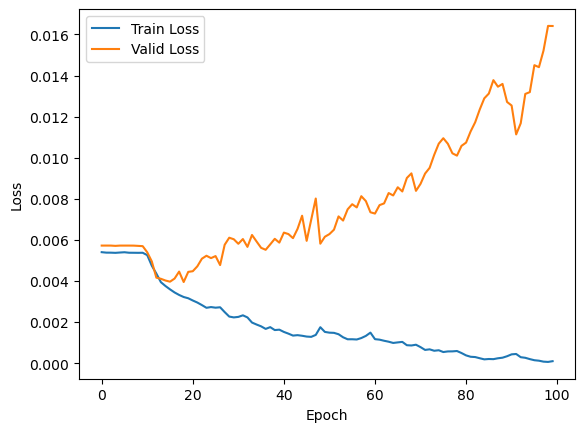

In [5]:
# 학습2: valid를 이용한 과적합 방지 epoch 찾기

# 학습과 검증 손실을 저장할 리스트 초기화
train_losses = []
valid_losses = []

# # 손실 함수와 옵티마이저 정의
criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
#criterion = nn.BCELoss() # 모델 출력이 시그모이드 활성화 함수를 거쳐 확률로 변환된 후의 값을 입력으로 받음. 입력 값은 0과 1사이의 확률 값.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

# 검증 데이터에 대한 모델 성능 평가 함수 정의
def evaluate(model, criterion, dataloader):
    model.eval()  # 모델을 평가 모드로 설정
    total_loss = 0.0
    
    with torch.no_grad():
        for batch_features, batch_targets in dataloader:
            # 배치를 GPU로 전송
            batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
            
            # 모델에 대한 순전파 및 손실 계산
            outputs = model(batch_features)
            loss = criterion(outputs, batch_targets)
            
            total_loss += loss.item()
    
    return total_loss / len(dataloader.dataset)  # 평균 손실 반환

# 학습 루프
for epoch in range(num_epochs):
    model.train()  # 모델을 학습 모드로 설정
    total_loss = 0.0
    
    for batch_features, batch_targets in train_loader:
        # 배치를 GPU로 전송
        batch_features, batch_targets = batch_features.to(device), batch_targets.to(device)
        
        # 모델에 대한 순전파 및 손실 계산
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_targets)
        
        # 역전파 및 최적화
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # 에폭마다 학습 손실 기록
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # 검증 데이터에 대한 손실 계산 및 기록
    valid_loss = evaluate(model, criterion, valid_loader)
    valid_losses.append(valid_loss)
    
    # 에폭마다 손실 출력
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss}, Valid Loss: {valid_loss}')

# 손실 함수 시각화
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Data Imbalance: Counter({1.0: 984, 0.0: 952})
Accuracy: 0.7149
Precision: 0.6782
Recall: 0.8354
F1 Score: 0.7486


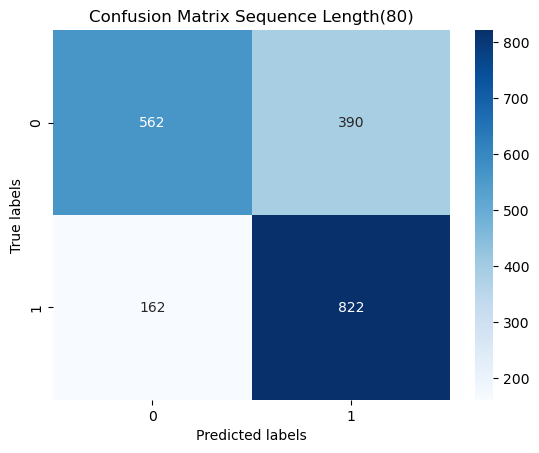

In [6]:
from collections import Counter

# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)

        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()

        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Data Imbalance: {Counter(y_true)}')
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title(f'Confusion Matrix Sequence Length({seq_len})')
plt.show()

### 6. 모델학습3: Optuna + CV 추가

In [33]:
# 데이터 불러오기 / Optuna 용 -> valid 제거
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_5.csv')
df = df.iloc[:20000]
df['returns_next10m'] = df['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 종속변수 이진분류화
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬

# sequence length를 기준으로 sequence 데이터 생성
seq_len = 20 # 20, 40, 80, 160, 320
X, y = sq.create_sequence(df, seq_len=seq_len)
# Tensor화
X = torch.FloatTensor(X).to(device)
y = torch.FloatTensor(y).to(device)
print('Full Data Size:', X.size(), y.size())

# split (70% / 30%)
split = int((X.size(0)) * 0.7)

X_train_seq = X[:split]
X_test_seq = X[split:]
y_train_seq = y[:split]
y_test_seq = y[split:]

print('Train Size:', X_train_seq.size(), y_train_seq.size())
print('Test Size:', X_test_seq.size(), y_test_seq.size())


Full Data Size: torch.Size([7669, 20, 77]) torch.Size([7669, 1])
Train Size: torch.Size([5368, 20, 77]) torch.Size([5368, 1])
Test Size: torch.Size([2301, 20, 77]) torch.Size([2301, 1])


In [17]:
# # 학습 3: Optuna + CV 추가
# import optuna
# from sklearn.model_selection import TimeSeriesSplit

# def objective(trial):
#     # K-Fold 교차 검증 설정
#     # k = 5  # 분할 수
#     # kf = KFold(n_splits=k, shuffle=True, random_state=42)
#     # TimeSeriesSplit 설정
#     tscv = TimeSeriesSplit(n_splits=5, gap=0) # gap: valid 전 train 데이터의 마지막 몇개 데이터 포인트를 제거하느냐

#     # 하이퍼파라미터 탐색 공간 정의
#     input_size = X.size(-1) # LSTM: X.shape[2](n_features), CNN-LSTM: X.size() -> CNN내에서 X.size(1)(seq_len)으로 input 실행
#     hidden_size = trial.suggest_int('hidden_size', 5, 100, step=5)
#     num_layers = trial.suggest_int('num_layers', 2, 5)
#     lr = trial.suggest_categorical('lr', [0.1, 0.01, 0.001, 0.0001])
#     num_epochs = 100  # 에폭 수는 고정값으로 설정

#     # 교차 검증을 위한 전체 손실 초기화
#     total_loss = 0.0

#     for train_idx, val_idx in tscv.split(X):
#         # 훈련 데이터와 검증 데이터로 분할
#         X_train_fold, X_val_fold = X[train_idx], X[val_idx]
#         y_train_fold, y_val_fold = y[train_idx], y[val_idx]

#         # DataLoader 설정
#         train_dataset = TensorDataset(X_train_fold, y_train_fold)
#         val_dataset = TensorDataset(X_val_fold, y_val_fold)
#         train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
#         val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

#         # 모델, 손실 함수, 옵티마이저 정의
#         model = CNNLSTMModel(input_size, hidden_size, num_layers, num_classes=1).to(device)
#         criterion = nn.BCEWithLogitsLoss() # 시그모이드 활성화 함수가 내장되어 있음. 모델의 마지막 레이어에서 시그모이드 함수 별도 적용할 필요X
#         optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#         # 모델 훈련
#         model.train()
#         for epoch in range(num_epochs):
#             for x_batch, y_batch in train_loader:
#                 x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#                 optimizer.zero_grad()
#                 outputs = model(x_batch)
#                 loss = criterion(outputs, y_batch)
#                 loss.backward()
#                 optimizer.step()

#         # 검증 손실 계산
#         model.eval()
#         with torch.no_grad():
#             val_loss = 0.0
#             for x_batch, y_batch in val_loader:
#                 x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#                 outputs = model(x_batch)
#                 loss = criterion(outputs, y_batch)
#                 val_loss += loss.item()
#             val_loss /= len(val_loader)

#         total_loss += val_loss

#     # 평균 검증 손실을 반환
#     avg_loss = total_loss / 5
#     return avg_loss

# # Optuna 최적화 실행
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)  # 시도 횟수는 10으로 설정

# print('Best trial:', study.best_trial.params)
# print("Best trial's value:", study.best_trial.value)


[I 2024-02-28 15:28:59,176] A new study created in memory with name: no-name-d6822665-db7f-4e2f-9eb1-f49e92bf51f4


[I 2024-02-28 15:29:46,390] Trial 0 finished with value: 0.7014174699783325 and parameters: {'hidden_size': 10, 'num_layers': 2, 'lr': 0.1}. Best is trial 0 with value: 0.7014174699783325.
[I 2024-02-28 15:30:57,182] Trial 1 finished with value: 0.7083777785301208 and parameters: {'hidden_size': 100, 'num_layers': 4, 'lr': 0.1}. Best is trial 0 with value: 0.7014174699783325.
[I 2024-02-28 15:31:54,308] Trial 2 finished with value: 0.7014065384864807 and parameters: {'hidden_size': 25, 'num_layers': 3, 'lr': 0.1}. Best is trial 2 with value: 0.7014065384864807.
[I 2024-02-28 15:33:07,379] Trial 3 finished with value: 0.7007116734981537 and parameters: {'hidden_size': 95, 'num_layers': 4, 'lr': 0.01}. Best is trial 3 with value: 0.7007116734981537.
[I 2024-02-28 15:34:08,575] Trial 4 finished with value: 0.7073028862476349 and parameters: {'hidden_size': 50, 'num_layers': 3, 'lr': 0.1}. Best is trial 3 with value: 0.7007116734981537.
[I 2024-02-28 15:35:36,268] Trial 5 finished with val

KeyboardInterrupt: 

### 7. Optuna(with. Pruner) + CV 추가

In [34]:
# 학습 4: Optuna(with. Pruner) + CV 추가
import optuna
from optuna.pruners import MedianPruner
from sklearn.model_selection import TimeSeriesSplit
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

def objective(trial):
    tscv = TimeSeriesSplit(n_splits=5, gap=0)

    input_size = X.size(-1)
    hidden_size = trial.suggest_int('hidden_size', 32, 256, step=32)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    lr = trial.suggest_categorical('lr', [0.01, 0.001, 0.0001])
    num_epochs = 100

    total_loss = 0.0

    for train_idx, val_idx in tscv.split(X):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        val_dataset = TensorDataset(X_val_fold, y_val_fold)
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

        model = CNNLSTMModel(input_size, hidden_size, num_layers, num_classes=1).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        model.train()
        for epoch in range(num_epochs):
            for x_batch, y_batch in train_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                loss.backward()
                optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
            val_loss /= len(val_loader)

        total_loss += val_loss

        # Pruner를 위한 조기 중단 로직
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    avg_loss = total_loss / 5
    return avg_loss

# MedianPruner 초기화 및 Optuna 최적화 실행
pruner = MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=50)

print('Best trial:', study.best_trial.params)
print("Best trial's value:", study.best_trial.value)


[I 2024-02-28 21:20:34,197] A new study created in memory with name: no-name-8852c764-fbe6-48e5-bb20-b0cdeaf9c5cd
c:\Users\com\anaconda3\Lib\site-packages\optuna\trial\_trial.py:499: UserWarning: The reported value is ignored because this `step` 99 is already reported.
  warnings.warn(
[I 2024-02-28 21:22:12,960] Trial 0 finished with value: 0.6910429483652114 and parameters: {'hidden_size': 96, 'num_layers': 3, 'lr': 0.01}. Best is trial 0 with value: 0.6910429483652114.
[I 2024-02-28 21:23:53,114] Trial 1 finished with value: 2.064844066500664 and parameters: {'hidden_size': 64, 'num_layers': 3, 'lr': 0.001}. Best is trial 0 with value: 0.6910429483652114.
[I 2024-02-28 21:25:38,778] Trial 2 finished with value: 1.4596738010644912 and parameters: {'hidden_size': 96, 'num_layers': 5, 'lr': 0.001}. Best is trial 0 with value: 0.6910429483652114.


In [ ]:
# 최적의 하이퍼파라미터로 모델 평가
best_params = study.best_trial.params

input_size = X_test_seq.size(-1)

# 모델을 최적의 하이퍼파라미터로 초기화
best_model = CNNLSTMModel(input_size, best_params['hidden_size'], best_params['num_layers'], num_classes=1).to(device)

# 손실 함수 및 옵티마이저 설정
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params['lr'])

# 모델을 평가 모드로 전환
best_model.eval()

y_true = []
y_pred = []

# 검증 데이터로 평가
with torch.no_grad(): # 기울기 계산X -> 메모리 사용량, 속도 줄어듬
    val_loss = 0.0
    for x_batch, labels in test_loader:
        x_batch, labels = x_batch.to(device), labels.to(device)
        # 로그 오즈를 확률로 변환
        probs = torch.sigmoid(outputs).squeeze()
        # 확률을 기준으로 0.5 이상이면 1, 미만이면 0으로 예측
        preds = torch.round(probs).cpu().numpy()
        y_true.extend(labels.squeeze().cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

SyntaxError: positional argument follows keyword argument (1180583119.py, line 7)